In [1]:
# 파이토피로 구현한 손글씨 데이터셋 모델
import torch
from torch import nn
from torch.utils.data import DataLoader # 모델에 데이터를 집어넣기 직전의 데이터
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 학습 데이터셋을 내려받음
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# 데이터로더를 생성. 텐서에서는 데이터 셋
# 전체 100, batch=10 -> 10번 반복 => 1에폭
# batch를 너무 작게하면 overfit문제 발생할 수 있음

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print('Shape of X [N, C, H, W] :', X.shape) # [batch, 데이터 순서, 행, 열]
  print('Shape of y :', y.shape, y.dtype) # y = label 값
  print(test_dataloader)
  print(y)
  break

Shape of X [N, C, H, W] : torch.Size([64, 1, 28, 28])
Shape of y : torch.Size([64]) torch.int64
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])


In [4]:
# 학습에 사용할 CPU장치나 GPU장치를 얻음
# GPU 장치로 사용 : 런타임 -> 런타임 유형변경 -> GPU -> 저장 -> 셀 모두실행 -> cuda 출력
# CPU 장치로 사용 : 런타임 -> 런타임 유형변경 -> None -> 저장 -> 셀 모두실행 -> cpu 출력
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('사용 중인 디바이스 : {}'.format(device))

사용 중인 디바이스 : cuda


In [5]:
# 모델을 정의
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__() #supuer() : 부모 호출. .__init__ : 생성자 / =>부모클래스 생성자 호출
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 128),  # Linear(input_dim, output_dim) = (크기, 받을 개수)
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10)
    )

  def forward(self, x): # 클래스 객체 실행시 자동으로 수행됨
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [6]:
# Linear(in_features=784, out_features=128, bias=True)
# bias = True : 해당 in_features, out_features에 의해 layer는 자동으로 학습함
# bias = False : 해당 in_features, out_features에 의해 layer는 자동으로 학습함하지 않음
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [7]:
# Loss 함수와 Optimizer 설정
# parameters() : iterator 객체 반환
# Adam에서 반환된 데이터를 파라미터 알고리즘에서 탐색함

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # lr : learning rate

In [8]:
# Training을 위한 함수
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset) 
  for batch, (X, y) in enumerate(dataloader): # enumerate : index 만들어줌
    #print("\nbatch\n",batch,'\nX',len(X), '\n', X,'\ny\n', y)  # 묶음데이터(index<937), 입력데이터(len(X)=64), 출력데이터(이미지에 해당하는 결과값)
    X, y = X.to(device), y.to(device) # 데이터와 같은 디바이스에 있어야하기 때문에 to()함수 사용

    # 예측 오류 계산
    pred = model(X)
    loss = loss_fn(pred, y)

    # 역전파(Back-Propagation)
    # 컴퓨터가 예측값의 정확도를 높이기 위해서 출력값과 실제 예측하고자 하는 값을 비교해서 가중치를 변경하는 작업
    # 1. 주어진 입력값에 상관없이 임의의 초기 가중치를 준 뒤 은닉층을 거쳐 결과를 계산
    # 2. 계산 결과와 실제 예측하고자 하는 값 사이의 오차를 구함
    # 3. 가중치를 업데이트
    # 4. 1~3의 과정을 오차가 더이상 줄지 않을 때까지 반복

    # AI에서 학습이란? 기울기(Gradient)가 작아지는 방향으로 업데이트를 반복하는 것 (=> loss가 작아지는 것)
    
    # 경사하강법(Gradient Descent)
    # 학습할 때 사용되는 전체 데이터를 미분하여 기울기가 낮은 쪽으로 이동시켜 극값을 구하면 이것을 
    # 근사값(예측값)으로 확정하는 원리(알고리즘). 한 번 업데이트 할 때마다 전체 데이터를 미분해야 하기 때문에 진행속도가 느림
    
    # SGD(확률적 경사 하강법) : 랜덤 추출된 일부 데이터를 사용하여 오차를 수정하기 전 수정값과 방향(+, -) 참고하여 변형시키는 방법
    # 경사하강법에서 전체 데이터를 미분하여 속도 느려지는 것을 해결


    # 시그모이드함수에서 기울기 최대값은 1 미만
    # 기울기를 계속 곱해주어 가중치 0에 수렴 => 기울기 소실
    # 기울기 소실을 해결하기 위해 나온게 relu

    optimizer.zero_grad() # optimizer : 오차값 누적(RNN에서 필요). zero_grad() : 에폭 한 번 실행될 때마다 기울기 초기화
    loss.backward() # 역전파
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss : {loss:>7f} [{current:>5d}/{size:>5d}]')


'''
Epochs 7w-------------
loss : 0.032187 [    0/60000]
loss : 0.014428 [ 6400/60000]
loss : 0.005297 [12800/60000]
loss : 0.033271 [19200/60000]
loss : 0.026597 [25600/60000]
loss : 0.024495 [32000/60000]
loss : 0.012751 [38400/60000]
loss : 0.035773 [44800/60000]
loss : 0.028658 [51200/60000]
loss : 0.032938 [57600/60000]
'''

'\nEpochs 7w-------------\nloss : 0.032187 [    0/60000]\nloss : 0.014428 [ 6400/60000]\nloss : 0.005297 [12800/60000]\nloss : 0.033271 [19200/60000]\nloss : 0.026597 [25600/60000]\nloss : 0.024495 [32000/60000]\nloss : 0.012751 [38400/60000]\nloss : 0.035773 [44800/60000]\nloss : 0.028658 [51200/60000]\nloss : 0.032938 [57600/60000]\n'

In [9]:
# Test를 위한 함수
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  #print(size)
  num_batches = len(dataloader)
  # Dropout layer 학습시에만 동작해야 함
  # train시 사용된 layer 동작을 멈추게 함
  model.eval()
  test_loss, current = 0, 0
  # autograd를 사용하지 않음으로 메모리 사용량을 줄이고 연산 속도를 높임
  # Grandient optimizer 기능 꺼줌
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      current += (pred.argmax(1) == y).type(torch.float).sum().item() # pred.argmax(1) : 10개의 데이터에서 가장 높은 값만 추출 -> 그 값들 더해줌
    test_loss /= num_batches
    current /= size
    print(f'Test Error : \n Accuracy : {(100*current):>0.1f}%, Avg loss : {test_loss:>8f}\n')


'''
Epochs 7w-------------
loss : 0.032187 [    0/60000]
loss : 0.014428 [ 6400/60000]
loss : 0.005297 [12800/60000]
loss : 0.033271 [19200/60000]
loss : 0.026597 [25600/60000]
loss : 0.024495 [32000/60000]
loss : 0.012751 [38400/60000]
loss : 0.035773 [44800/60000]
loss : 0.028658 [51200/60000]
loss : 0.032938 [57600/60000]

Accuracy : %, Avg loss: 
'''

'\nEpochs 7w-------------\nloss : 0.032187 [    0/60000]\nloss : 0.014428 [ 6400/60000]\nloss : 0.005297 [12800/60000]\nloss : 0.033271 [19200/60000]\nloss : 0.026597 [25600/60000]\nloss : 0.024495 [32000/60000]\nloss : 0.012751 [38400/60000]\nloss : 0.035773 [44800/60000]\nloss : 0.028658 [51200/60000]\nloss : 0.032938 [57600/60000]\n\nAccuracy : %, Avg loss: \n'

In [10]:
epochs = 10
for t in range(epochs):
  print(f'Epochs {t+1}w-------------')
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print('끝')

Epochs 1w-------------
loss : 2.302310 [    0/60000]
loss : 0.482813 [ 6400/60000]
loss : 0.342738 [12800/60000]
loss : 0.367436 [19200/60000]
loss : 0.233986 [25600/60000]
loss : 0.341952 [32000/60000]
loss : 0.173991 [38400/60000]
loss : 0.373904 [44800/60000]
loss : 0.240253 [51200/60000]
loss : 0.260305 [57600/60000]
Test Error : 
 Accuracy : 94.0%, Avg loss : 0.199095

Epochs 2w-------------
loss : 0.139735 [    0/60000]
loss : 0.180127 [ 6400/60000]
loss : 0.113798 [12800/60000]
loss : 0.216675 [19200/60000]
loss : 0.165402 [25600/60000]
loss : 0.253728 [32000/60000]
loss : 0.073836 [38400/60000]
loss : 0.249681 [44800/60000]
loss : 0.193769 [51200/60000]
loss : 0.222952 [57600/60000]
Test Error : 
 Accuracy : 96.1%, Avg loss : 0.129830

Epochs 3w-------------
loss : 0.078447 [    0/60000]
loss : 0.134561 [ 6400/60000]
loss : 0.075544 [12800/60000]
loss : 0.110756 [19200/60000]
loss : 0.109053 [25600/60000]
loss : 0.162239 [32000/60000]
loss : 0.050797 [38400/60000]
loss : 0.2085

In [11]:
import os
from PIL import Image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('file : {name}, lenght : {length}bytes'.format(name=fn, length=len(uploaded[fn])))

Saving image.png to image.png
file : image.png, lenght : 912bytes


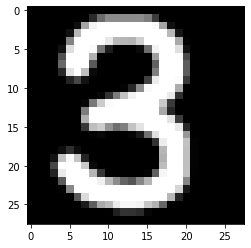

In [12]:
cur_dir = os.getcwd()
img_path = os.path.join(cur_dir, 'image.png')

cur_img = Image.open(img_path)

cur_img = cur_img.resize((28, 28))
image = np.asarray(cur_img)

try :
  image = np.mean(image, axis=2)  # gray scale 색상 바꿀 수 있음
except :
  pass

image = np.abs(255-image) # 색상 반전
image = image.astype(np.float32) / 255  # 정규화
plt.imshow(image, cmap='gray')
plt.show()

In [13]:
image = torch.as_tensor(image).to(device).reshape(1, 1, 28, 28) # 디바이스 : GPU. (1, 1, 28: 너비, 28:높이) : 하나씩 28*28 를 집어넣어줌
model.eval()  # 학습시킬 때 필요없는 layer 끄는 함수
predict = model(image)
print('model이 예측한 값 : {}'.format(predict.argmax(1).item()))

model이 예측한 값 : 3


In [14]:
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()    
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



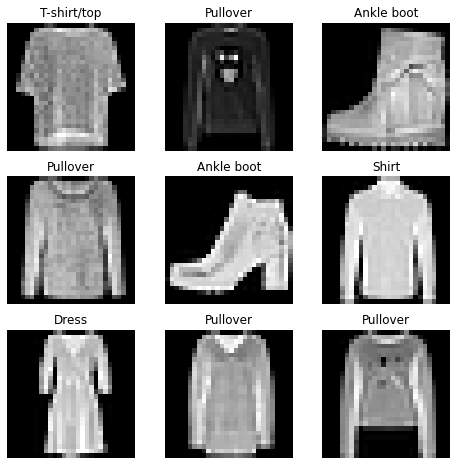

In [15]:
labels_map = {
    0 : 'T-shirt/top', 
    1 : 'Trouser', 
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot'
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()  # len(training_data) : (a,b)???? => a<= x <= b 범위를 나타냄. 리스트에서 맨 앞의 값만 추출
  #print(sample_idx))
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray')  # 채널을 없애줌. 1을 삭제, 28*28 <-> unsqueeze() : 차원을 생성
plt.show()

In [16]:
# DataLoader 만들기
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape : torch.Size([64, 1, 28, 28])
Labels batch shape : torch.Size([64])


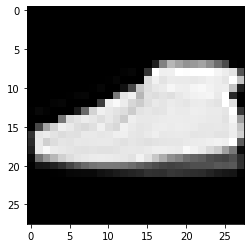

Label : 9


In [17]:
train_features, train_labels = next(iter(train_dataloader)) # 문제와 정답을 나눔
print(f'Feature batch shape : {train_features.size()}')
print(f'Labels batch shape : {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label : {label}')

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('사용하는 디바이스 : {}'.format(device))

사용하는 디바이스 : cuda


In [19]:
# model class 만들기
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__() #supuer() : 부모 호출. .__init__ : 생성자 / =>부모클래스 생성자 호출
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28, 128),  # (크기, 받을 개수).  Linear layer랑 tensorflow의 dense layer랑 비슷 but 차이점 : 여기 linear은 input layer이고 연산이 안됌
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(128, 10)  # 클래스(labels) 10개 출력 - 0 : 'T-shirt/top', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress',...9 : 'Ankle boot'
    )

  def forward(self, x): # 클래스 객체 실행시 자동으로 수행됨
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [20]:
# Model 객체 생성
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [21]:
# 가상의 데이터를 만들어서 예측 - 모델, 결과 의미없음
X = torch.rand(1, 28, 28, device=device)  # (1, 28, 28) : 한장의 크기 28*28
logits = model(X) # nn.Linear(128, 10) => 데이터 10개 출력
pred_probab = nn.Softmax(dim=1)(logits) # softmax가 값 10개를 받아서 각 label에 대한 확률로 바꿈
y_pred = pred_probab.argmax(1)  # 확률 중 가장 값이 높은 것 찾음
print(f'예측된 클래스 : {y_pred}')


예측된 클래스 : tensor([1], device='cuda:0')


In [22]:
loss_fn = nn.CrossEntropyLoss()

In [23]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  for batch, (X, y) in enumerate(dataloader): # enumerate : index 만들어줌
    #print("\nbatch\n",batch,'\nX',len(X), '\n', X,'\ny\n', y)  # 묶음데이터(index<937), 입력데이터(len(X)=64), 출력데이터(이미지에 해당하는 결과값)
    X, y = X.to(device), y.to(device) # 데이터와 같은 디바이스에 있어야하기 때문에 to()함수 사용

    # 예측 오류 계산
    pred = model(X)
    loss = loss_fn(pred, y)

    # optimizer.zero_grad()
    # gradient값들을 backward를 해줄 때 계속 값이 누적되기 때문에 loss.backward()를 호출 할 때 초기설정을 매번 더해주므로 한번의 학습이 끝나면 값을 0으로 초기화 해주기 위해 사용
    optimizer.zero_grad() # optimizer : gradient값들을 backward를 해줄 때 계속 값이 누적(오차값 누적)(RNN에서 필요). zero_grad() : 에폭 한 번 실행될 때마다 기울기 초기화
    loss.backward() # 역전파 일어남
    optimizer.step()  # optimizer 실행 => 기울기 업데이트

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f'loss : {loss:>7f} [{current:>5d}/{size:>5d}]')

In [25]:
def test_loop(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  #print(size)
  num_batches = len(dataloader)
  # Dropout layer 학습시에만 동작해야 함
  # train시 사용된 layer 동작을 멈추게 함
  model.eval()
  test_loss, current = 0, 0
  
  # autograd를 사용하지 않음으로 메모리 사용량을 줄이고 연산 속도를 높임
  # Grandient optimizer 기능 꺼줌
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      current += (pred.argmax(1) == y).type(torch.float).sum().item() # pred.argmax(1) : 10개의 데이터에서 가장 높은 값만 추출 -> 그 값들 더해줌
    test_loss /= num_batches
    current /= size
    print(f'Test Error : \n Accuracy : {(100*current):>0.1f}%, Avg loss : {test_loss:>8f}\n')

In [26]:
# 학습
epochs = 10
for t in range(epochs):
  print(f'Epochs {t+1}w-------------')
  train(train_dataloader, model, loss_fn, optimizer)
  test(test_dataloader, model, loss_fn)
print('끝')

Epochs 1w-------------
loss : 2.342281 [    0/60000]
loss : 0.915635 [ 6400/60000]
loss : 0.541142 [12800/60000]
loss : 0.668217 [19200/60000]
loss : 0.567039 [25600/60000]
loss : 0.468341 [32000/60000]
loss : 0.437798 [38400/60000]
loss : 0.392829 [44800/60000]
loss : 0.565964 [51200/60000]
loss : 0.644085 [57600/60000]
Test Error : 
 Accuracy : 83.7%, Avg loss : 0.459347

Epochs 2w-------------
loss : 0.550816 [    0/60000]
loss : 0.651186 [ 6400/60000]
loss : 0.364620 [12800/60000]
loss : 0.502833 [19200/60000]
loss : 0.395601 [25600/60000]
loss : 0.388944 [32000/60000]
loss : 0.452660 [38400/60000]
loss : 0.393211 [44800/60000]
loss : 0.389636 [51200/60000]
loss : 0.484641 [57600/60000]
Test Error : 
 Accuracy : 85.2%, Avg loss : 0.409161

Epochs 3w-------------
loss : 0.509297 [    0/60000]
loss : 0.379686 [ 6400/60000]
loss : 0.398178 [12800/60000]
loss : 0.441076 [19200/60000]
loss : 0.349915 [25600/60000]
loss : 0.364171 [32000/60000]
loss : 0.277956 [38400/60000]
loss : 0.3002

In [28]:
# 학습된 model parameter 저장
torch.save(model.state_dict(), 'model_weights.pth') # 학습된 내용 저장. (딕셔너리로 저장, 파일명.확장명)

In [29]:
# 새 model instance를 생성. 학습되 내용X
model2 = NeuralNetwork().to(device)
print(model2)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [30]:
# 테스트
model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Error : 
 Accuracy : 14.4%, Avg loss : 2.305533



In [31]:
# 저장된 parameter 불러오기
model2.load_state_dict(torch.load('model_weights.pth'))

model2.eval()
test_loop(test_dataloader, model2, loss_fn)

Test Error : 
 Accuracy : 88.3%, Avg loss : 0.328792



In [32]:
# model 전체를 저장하고 불러오기
torch.save(model, 'model.pth')

In [33]:
# 불러오기
model3 = torch.load('model.pth')

In [34]:
# 테스트
model3.eval()
test_loop(test_dataloader, model3, loss_fn)

Test Error : 
 Accuracy : 88.3%, Avg loss : 0.328858

